In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-dataset/test_data.parquet
/kaggle/input/amex-dataset/add_event.parquet
/kaggle/input/amex-dataset/685404e30cfdb_submission_template.csv
/kaggle/input/amex-dataset/data_dictionary.csv
/kaggle/input/amex-dataset/offer_metadata.parquet
/kaggle/input/amex-dataset/add_trans.parquet
/kaggle/input/amex-dataset/68524025db373_Campus_Challenge25_Amex_Offer.pdf
/kaggle/input/amex-dataset/train_data.parquet


In [4]:
import pandas as pd
import numpy as np

# === STEP 1: Load train and data dictionary ===
train = pd.read_parquet("/kaggle/input/amex-dataset/train_data.parquet")
data_dict = pd.read_csv("/kaggle/input/amex-dataset/data_dictionary.csv")

In [6]:
# Manual fix: remove suffixes like .1, .2 etc. by keeping only base names and ensuring uniqueness
def dedup_columns(cols):
    seen = {}
    new_cols = []
    for col in cols:
        base = col.split('.')[0]
        if base not in seen:
            seen[base] = 1
            new_cols.append(base)
        else:
            seen[base] += 1
            new_cols.append(f"{base}_{seen[base]}")
    return new_cols

train.columns = dedup_columns(train.columns)

In [7]:
# === STEP 3: Build dtype and column name mappings ===
dtype_map = {}
col_name_map = {}

for _, row in data_dict.iterrows():
    masked = row['masked_column']
    if masked not in dtype_map:
        dtype_map[masked] = row['Type']
        name = row['Description'] if pd.notna(row['Description']) else masked
        name_clean = (
            name.strip()
                .lower()
                .replace(" ", "_")
                .replace("(", "")
                .replace(")", "")
                .replace("-", "_")
                .replace(":", "")
        )
        col_name_map[masked] = name_clean


In [8]:
# === STEP 4: Rename columns using the mapping ===
for original, clean in col_name_map.items():
    matching_cols = [c for c in train.columns if c.startswith(original)]
    if len(matching_cols) == 1:
        train.rename(columns={matching_cols[0]: clean}, inplace=True)

In [9]:
# === STEP 5: Apply dtypes ===
for masked_col, typ in dtype_map.items():
    clean_col = col_name_map.get(masked_col)
    if clean_col not in train.columns:
        continue
    try:
        if typ in ["Numerical", "Binary"]:
            train[clean_col] = pd.to_numeric(train[clean_col], errors="coerce")
        elif typ == "Categorical":
            train[clean_col] = train[clean_col].astype("category")
    except Exception as e:
        print(f"⚠️ Error converting {clean_col} to {typ}: {e}")


⚠️ Error converting no._of_pages_viewed_ratio_variable to Numerical: arg must be a list, tuple, 1-d array, or Series
⚠️ Error converting no._of_pages_viewed_ratio_variable to Numerical: arg must be a list, tuple, 1-d array, or Series
⚠️ Error converting no._of_pages_viewed_ratio_variable to Numerical: arg must be a list, tuple, 1-d array, or Series
⚠️ Error converting no._of_impressions_for_a_cm_in_the_last_14_days_where_past_impressions_get_decaying_weights to Numerical: arg must be a list, tuple, 1-d array, or Series
⚠️ Error converting no_of_clicks_for_a_cm_in_the_last_30_days_where_past_clicks_get_decaying_weights to Numerical: arg must be a list, tuple, 1-d array, or Series
⚠️ Error converting no_of_clicks_for_a_cm_in_the_last_14_days_where_past_clicks_get_decaying_weights to Numerical: arg must be a list, tuple, 1-d array, or Series
⚠️ Error converting context_variable_fetched_in_real_time_where_this_is_number_of_seconds_after_0000_hrs to Numerical: arg must be a list, tuple, 1-d

In [10]:
# === STEP 6: Attempt to convert remaining object columns (except IDs) ===
id_cols = ['primary_keymasked', 'customer_id_masked', 'dependent_variable']
object_cols = train.select_dtypes(include='object').columns.difference(id_cols)

for col in object_cols:
    try:
        train[col] = pd.to_numeric(train[col], errors='coerce')
    except:
        pass  # leave as is

In [11]:
# === STEP 7: Final Summary ===
print("\n✅ Final Data Type Summary:")
print(train.dtypes.value_counts())

print("\n🧹 Still object-type columns (if any):")
print(train.select_dtypes(include='object').columns.tolist())

print(f"\n📐 Final train shape: {train.shape}")



✅ Final Data Type Summary:
float64     340
object       20
category      2
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
Name: count, dtype: int64

🧹 Still object-type columns (if any):
['primary_keymasked', 'customer_id_masked', 'dependent_variable', 'no._of_pages_viewed_ratio_variable', 'no._of_pages_viewed_ratio_variable', 'no._of_pages_viewed_ratio_variable', 'no._of_impressions_for_a_cm_in_the_last_14_days_where_past_impressions_get_decaying_weights', 'no_of_clicks_for_a_cm_in_the_last_30_days_where_past_clicks_get_decaying_weights', 'no_of_clicks_for_a_cm_in_the_last_14_days_where_past_clicks_get_decaying_weights', 'context_variable_fetched_in_real_time_where_this_is_number_of_seconds_after_0000_hrs', 'no_of_clicks_for_a_cm_in_the_last_30_days_where_past_clicks_get_decaying_weights', 'no_of_clicks_for_a_cm_in_the_last_14_days_where_past_clicks_get_decaying_weights', 

In [12]:
from collections import Counter

# Step 1: Count duplicate column names
col_counts = Counter(train.columns)
dup_cols = [col for col, count in col_counts.items() if count > 1]

print(f"🔁 Found {len(dup_cols)} duplicated column names")


🔁 Found 7 duplicated column names


In [13]:
# Step 2: For each duplicate column name, resolve into one
for col in dup_cols:
    matching_cols = [c for c in train.columns if c == col]
    
    # Collapse into a single column using first non-null across columns
    train[col + "_cleaned"] = train[matching_cols].bfill(axis=1).iloc[:, 0]
    
    # Drop all old duplicate columns
    train.drop(columns=matching_cols, inplace=True)
    
    # Rename cleaned column to original
    train.rename(columns={col + "_cleaned": col}, inplace=True)

/tmp/ipykernel_36/612395840.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[col + "_cleaned"] = train[matching_cols].bfill(axis=1).iloc[:, 0]
/tmp/ipykernel_36/612395840.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[col + "_cleaned"] = train[matching_cols].bfill(axis=1).iloc[:, 0]
/tmp/ipykernel_36/612395840.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.con

In [14]:
# Step 3: Try numeric conversion on remaining object columns (except IDs)
id_cols = ['primary_keymasked', 'customer_id_masked', 'dependent_variable']
obj_cols = train.select_dtypes(include='object').columns.difference(id_cols)

for col in obj_cols:
    train[col] = pd.to_numeric(train[col], errors='coerce')


In [15]:
# Step 4: Summary check
print("\n✅ Cleaned all duplicates and coerced to numeric.")
print("Data types now:")
print(train.dtypes.value_counts())

print("\n🧹 Final object-type columns (if any):")
print(train.select_dtypes(include='object').columns.tolist())



✅ Cleaned all duplicates and coerced to numeric.
Data types now:
float64     347
object        3
category      2
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
Name: count, dtype: int64

🧹 Final object-type columns (if any):
['primary_keymasked', 'customer_id_masked', 'dependent_variable']


In [16]:
from sklearn.model_selection import train_test_split

# 🎯 Define target column
TARGET_COL = "dependent_variable"

# 1️⃣ Separate features and target
X = train.drop(columns=[TARGET_COL, "primary_keymasked"], errors="ignore")
y = train[TARGET_COL].astype(int)  # convert from object to int

# 2️⃣ First split: train_val (85%) and test (15%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# 3️⃣ Then split train_val into train (85%) and val (15% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.15 / 0.85, stratify=y_trainval, random_state=42
)

# 🧾 Print class balance for sanity check
for name, y_split in zip(["Train", "Val", "Test"], [y_train, y_val, y_test]):
    click_rate = y_split.mean()
    print(f"{name:<5} → Size: {len(y_split):>7,} | Click rate: {click_rate:.4f}")


Train → Size: 539,114 | Click rate: 0.0481
Val   → Size: 115,525 | Click rate: 0.0481
Test  → Size: 115,525 | Click rate: 0.0481


In [19]:
def preprocess_train(X):
    # 1. Drop high missing columns
    missing_pct = X.isna().mean()
    drop_cols = missing_pct[missing_pct > 0.95].index.tolist()

    # 2. Drop constant columns
    constant_cols = [col for col in X.columns if X[col].nunique(dropna=False) <= 1 or X[col].value_counts(normalize=True, dropna=False).iloc[0] > 0.999]
    
    # Final list of columns to drop
    drop_all = list(set(drop_cols + constant_cols))

    # 3. Map Y/N/None etc.
    yn_map = {'Y': 1, 'N': 0, 'NY': 0.5, 'None': np.nan, None: np.nan}
    yn_cols = []
    for col in X.columns:
        if X[col].dtype == object and X[col].dropna().isin(['Y', 'N', 'NY', 'None']).all():
            yn_cols.append(col)

    # 4. Replace 0s with NaN in select features
    cant_be_zero_cols = [...]  # same as before

    # Apply all changes
    X_clean = X.drop(columns=drop_all).copy()
    for col in yn_cols:
        X_clean[col] = X_clean[col].map(yn_map)
    for col in cant_be_zero_cols:
        if col in X_clean.columns:
            X_clean[col] = X_clean[col].replace(0, np.nan)

    return X_clean, drop_all, yn_cols


In [20]:
X_train_clean, drop_cols, yn_cols = preprocess_train(X_train)

In [22]:
# Features where 0 is considered invalid and should be set to NaN
cant_be_zero_cols = [
    'f28', 'f60', 'f106', 'f109', 'f166', 'f193', 'f194', 'f205', 'f227', 'f228', 
    'f293', 'f294', 'f297', 'f303', 'f306', 'f311', 'f312', 'f321', 'f353', 'f365', 
    'f33', 'f157', 'f241', 'f244', 'f279', 'f284', 'f325', 'f172', 'f248', 'f299', 'f358'
]

In [23]:
# Now apply same logic to val/test
def preprocess_other(X, drop_cols, yn_cols):
    X_clean = X.drop(columns=drop_cols, errors='ignore').copy()
    yn_map = {'Y': 1, 'N': 0, 'NY': 0.5, 'None': np.nan, None: np.nan}
    for col in yn_cols:
        if col in X_clean.columns:
            X_clean[col] = X_clean[col].map(yn_map)
    for col in cant_be_zero_cols:
        if col in X_clean.columns:
            X_clean[col] = X_clean[col].replace(0, np.nan)
    return X_clean

X_val_clean = preprocess_other(X_val, drop_cols, yn_cols)
X_test_clean = preprocess_other(X_test, drop_cols, yn_cols)

In [25]:
from sklearn.experimental import enable_iterative_imputer  # ✅ Enable experimental features
from sklearn.impute import IterativeImputer                # ✅ Now import


# Step 1: Select only numerical columns
num_cols = X_train_clean.select_dtypes(include='float64').columns.tolist()

In [26]:
# Step 2: Initialize and fit
imputer = IterativeImputer(random_state=42, max_iter=10, initial_strategy='mean')

In [27]:
# # Step 3: Fit on training data and transform all splits
# X_train_imputed = X_train_clean.copy()
# X_val_imputed = X_val_clean.copy()
# X_test_imputed = X_test_clean.copy()

# # Fit only on train numerical features
# X_train_imputed[num_cols] = imputer.fit_transform(X_train_clean[num_cols])

# # Use fitted imputer on val and test
# X_val_imputed[num_cols] = imputer.transform(X_val_clean[num_cols])
# X_test_imputed[num_cols] = imputer.transform(X_test_clean[num_cols])


KeyboardInterrupt: 

In [28]:
from sklearn.impute import SimpleImputer

# 1. Select columns
num_cols = X_train_clean.select_dtypes(include='float64').columns.tolist()
cat_cols = X_train_clean.select_dtypes(include='category').columns.tolist()

# 2. Numerical Imputer (median)
num_imputer = SimpleImputer(strategy='median')
X_train_clean[num_cols] = num_imputer.fit_transform(X_train_clean[num_cols])
X_val_clean[num_cols] = num_imputer.transform(X_val_clean[num_cols])
X_test_clean[num_cols] = num_imputer.transform(X_test_clean[num_cols])

# 3. Categorical Imputer (mode)
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train_clean[cat_cols] = cat_imputer.fit_transform(X_train_clean[cat_cols])
X_val_clean[cat_cols] = cat_imputer.transform(X_val_clean[cat_cols])
X_test_clean[cat_cols] = cat_imputer.transform(X_test_clean[cat_cols])


In [29]:
print("🔍 Checking for NaNs...")

print("Train NaNs:", X_train_clean.isna().sum().sum())
print("Val   NaNs:", X_val_clean.isna().sum().sum())
print("Test  NaNs:", X_test_clean.isna().sum().sum())


🔍 Checking for NaNs...
Train NaNs: 0
Val   NaNs: 0
Test  NaNs: 0


In [30]:
# Group info for ranking
group_train = X_train_clean.groupby("customer_id_masked").size().values
group_val = X_val_clean.groupby("customer_id_masked").size().values
group_test = X_test_clean.groupby("customer_id_masked").size().values

In [31]:
id_cols = ['primary_keymasked', 'customer_id_masked', 'offer_id', 'event_timestamp', 'event_date']
X_train_feats = X_train_clean.drop(columns=id_cols, errors='ignore')
X_val_feats = X_val_clean.drop(columns=id_cols, errors='ignore')
X_test_feats = X_test_clean.drop(columns=id_cols, errors='ignore')


In [34]:
# Step 1: Identify object columns
obj_cols = X_train_feats.select_dtypes(include='object').columns.tolist()


In [41]:
# Only drop object columns that are still present in the DataFrame
obj_cols = X_train_feats.select_dtypes(include='object').columns.tolist()

# Sanity-check and keep only existing columns
obj_cols = [col for col in obj_cols if col in X_train_feats.columns]

# Drop object columns from all splits
X_train_feats = X_train_feats.drop(columns=obj_cols)
X_val_feats = X_val_feats.drop(columns=obj_cols)
X_test_feats = X_test_feats.drop(columns=obj_cols)

print(f"Dropped {len(obj_cols)} object columns.")


Dropped 0 object columns.


In [43]:
def clean_column_names(df):
    df.columns = (
        df.columns.str.replace(r'[^0-9a-zA-Z_]', '_', regex=True)  # Replace invalid chars with underscore
                  .str.replace(r'_+', '_', regex=True)             # Collapse multiple underscores
                  .str.strip('_')                                  # Remove leading/trailing _
    )
    return df

# Clean feature names in all splits
X_train_feats = clean_column_names(X_train_feats)
X_val_feats = clean_column_names(X_val_feats)
X_test_feats = clean_column_names(X_test_feats)


In [45]:
# Step 1: Check for duplicate columns
dupe_cols = X_train_feats.columns[X_train_feats.columns.duplicated()].tolist()
print("🛑 Duplicate columns found:", dupe_cols)

🛑 Duplicate columns found: ['number_of_clicks_for_category_services_in_last_60_days', 'no_of_pages_viewed_ratio_variable']


In [46]:
# Step 2: Drop duplicates (keep only the first occurrence)
X_train_feats = X_train_feats.loc[:, ~X_train_feats.columns.duplicated()]
X_val_feats = X_val_feats.loc[:, ~X_val_feats.columns.duplicated()]
X_test_feats = X_test_feats.loc[:, ~X_test_feats.columns.duplicated()]


In [47]:
from lightgbm import LGBMRanker
from lightgbm import early_stopping, log_evaluation
ranker = LGBMRanker(
    objective="lambdarank",
    metric="map",
    boosting_type="gbdt",
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    random_state=42,
    verbosity=-1
)

# ✅ Now re-run the model training
ranker.fit(
    X_train_feats, y_train,
    group=group_train,
    eval_set=[(X_val_feats, y_val)],
    eval_group=[group_val],
    eval_at=[7],
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(period=50)
    ]
)


Training until validation scores don't improve for 30 rounds
[50]	valid_0's map@7: 0.972413
[100]	valid_0's map@7: 0.975408
[150]	valid_0's map@7: 0.977251
[200]	valid_0's map@7: 0.978626
[250]	valid_0's map@7: 0.978887
[300]	valid_0's map@7: 0.979449
Did not meet early stopping. Best iteration is:
[300]	valid_0's map@7: 0.979449


LGBMRanker(learning_rate=0.05, metric='map', n_estimators=300,
           objective='lambdarank', random_state=42, verbosity=-1)

In [48]:
import numpy as np

def apk(actual, predicted, k=7):
    """Average Precision at k"""
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)


def mapk(y_true_dict, y_pred_dict, k=7):
    """Mean Average Precision at k"""
    return np.mean([
        apk(y_true_dict[cid], y_pred_dict[cid], k)
        for cid in y_true_dict
    ])


In [49]:
# Merge predictions into a DataFrame
test_preds = X_test.copy()
test_preds['score'] = ranker.predict(X_test_feats)
test_preds['actual'] = y_test.values

# Group offers per customer
y_pred_dict = (
    test_preds
    .sort_values(['customer_id_masked', 'score'], ascending=[True, False])
    .groupby('customer_id_masked')['offer_id']
    .apply(list)
    .to_dict()
)

y_true_dict = (
    test_preds[test_preds['actual'] == 1]
    .groupby('customer_id_masked')['offer_id']
    .apply(list)
    .to_dict()
)

# Evaluate
print("MAP@7 on test set:", mapk(y_true_dict, y_pred_dict, k=7))


MAP@7 on test set: 0.6893277710679618


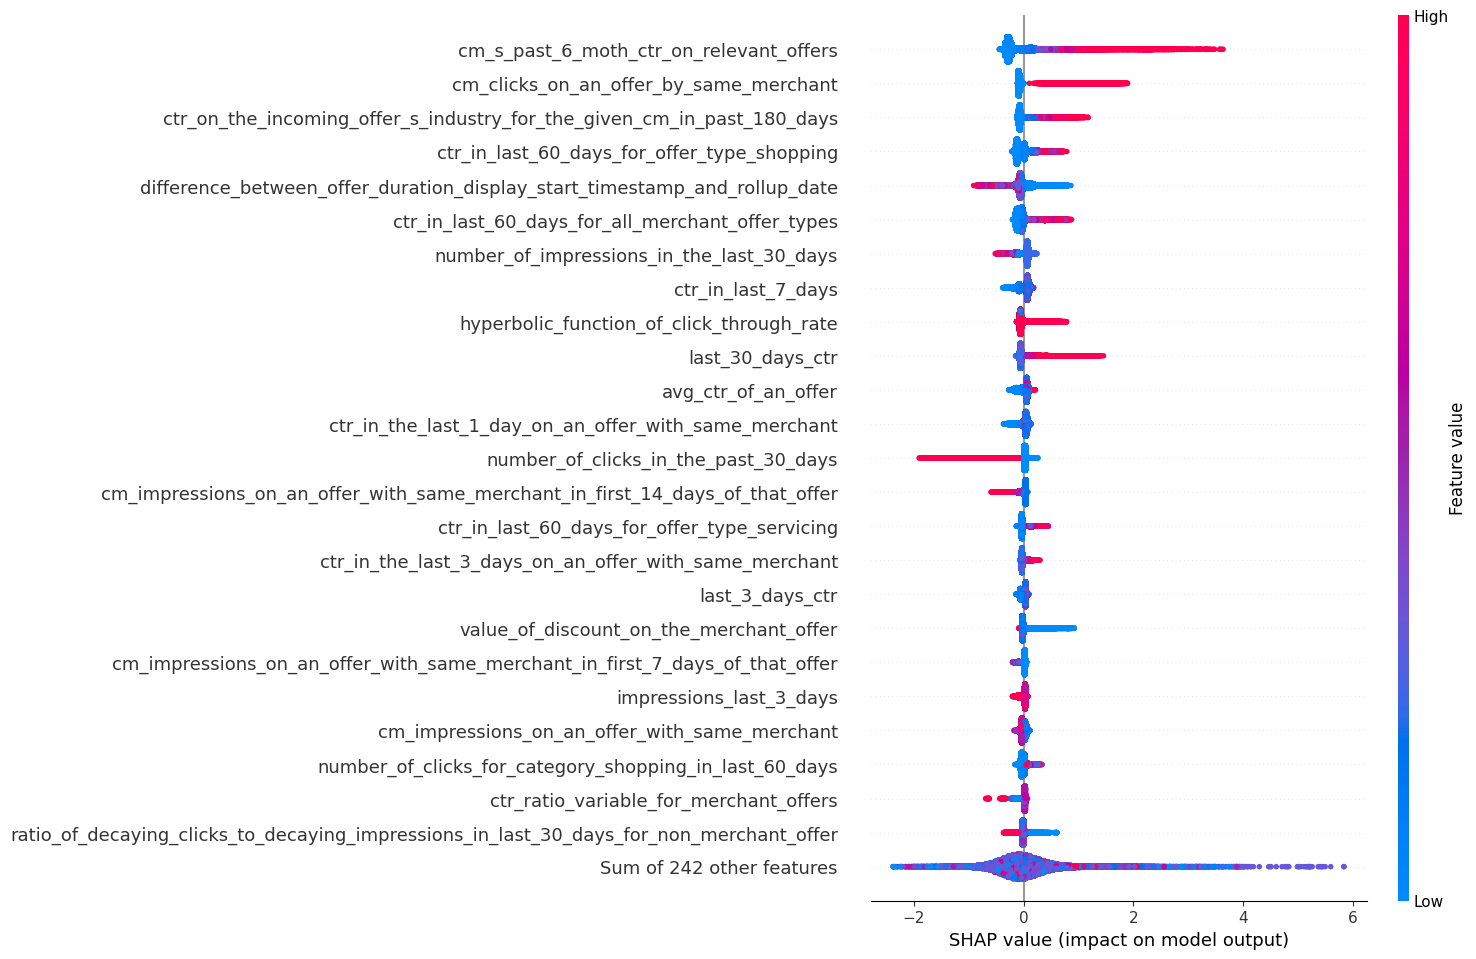

In [51]:
import shap
import matplotlib.pyplot as plt


# 2. Create TreeExplainer using your trained model
explainer = shap.Explainer(ranker)

# 3. Compute SHAP values
shap_values = explainer(X_val_feats)

# 4. Plot summary of SHAP values
shap.plots.beeswarm(shap_values, max_display=25)
